2.18.0
True
(30000, 25)


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


2    18112
1    18112
Name: SEX, dtype: int64
4.0311111111111115
PR-AUC: 0.579431159475316
Model Accuracy: 0.8428
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7307
           1       0.67      0.37      0.47      1749

    accuracy                           0.84      9056
   macro avg       0.77      0.66      0.69      9056
weighted avg       0.83      0.84      0.82      9056


Final Training Log Loss: 0.3013
Final Test Log Loss: 0.3953


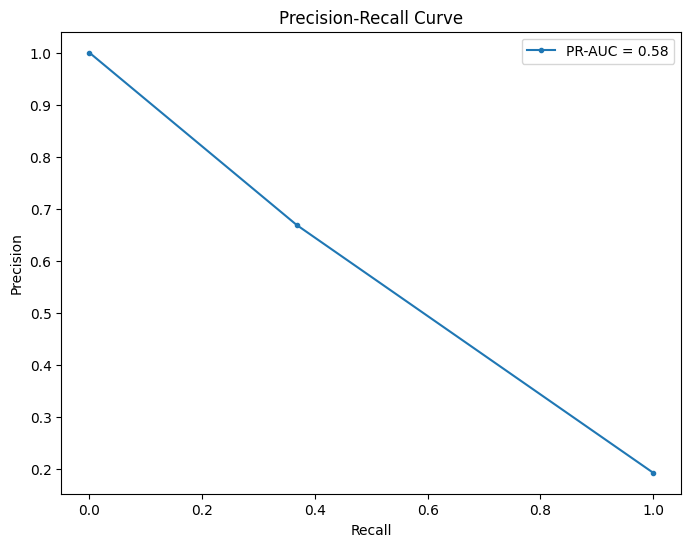

In [2]:
%run /home/jui/thesis-code/Thesis-code/rai-img-merged/Improved-model.ipynb

In [3]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

# Convert DataFrame to NumPy array for XGBoost
X_train_np = X_train.to_numpy()

# Ensure labels are in the correct shape
y_train_np = np.array(y_train).flatten()

# Assuming train_og_np and y_train_np are NumPy arrays
subset_indices = np.random.choice(X_train_np.shape[0], 7500, replace=False)

# Select random 7500 samples
X_train_subset = X_train_np[subset_indices]
y_train_subset = y_train[subset_indices]

def get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2):
    # Define XGBoost parameters
    num_round = 10
    param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': num_classes}

    # Train XGBoost model
    train_data = xgb.DMatrix(X_train_subset, label=y_train_subset)
    model = xgb.train(param, train_data, num_round)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(model=model, nb_features=X_train_subset.shape[1], nb_classes=num_classes)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)
    
    # Generate adversarial samples
    x_train_adv = zoo.generate(X_train_subset)

    return x_train_adv

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
x_train_adv = get_adversarial_examples(X_train_subset, y_train_subset, num_classes=2)

ZOO: 100%|██████████| 7500/7500 [05:19<00:00, 23.45it/s]


Accuracy on Test Set: 83.24%


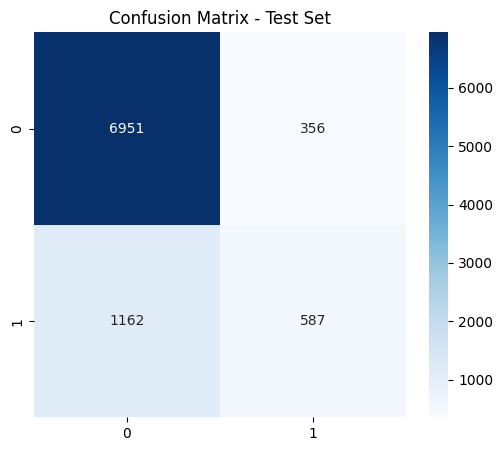

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Convert all datasets to NumPy arrays before training
xgb_model.fit(x_train_adv, y_train_subset,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [6]:
def label_flip_attack(y_train: np.ndarray, flip_percent: float) -> np.ndarray:
    """
    Flip labels in y_train by a specified percentage.
    
    Args:
        y_train (np.ndarray): Original training labels.
        flip_percent (float): Percentage of labels to flip (0-100).

    Returns:
        np.ndarray: Poisoned labels with flipped values.
    """
    y_poisoned = y_train.copy()
    n_samples = len(y_train)
    n_flip = int((flip_percent / 100) * n_samples)  # Number of labels to flip
    
    flip_indices = np.random.choice(np.arange(n_samples), size=n_flip, replace=False)

    # Flip binary labels (assuming labels are 0 and 1)
    y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]  # Flip 0->1 and 1->0
    
    return y_poisoned



Accuracy on Test Set: 78.07%


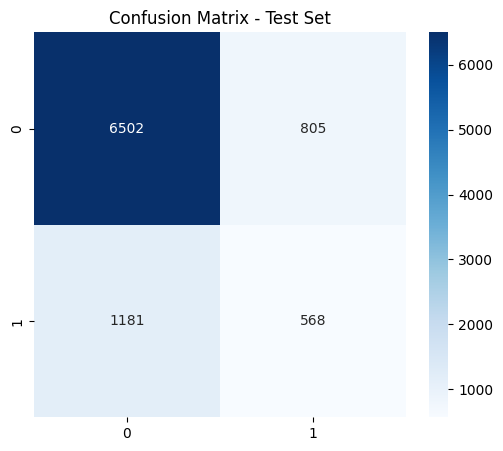

In [7]:
# Define the percentage of labels to flip
flip_percent = 35  # Flip 20% of labels

# Apply label flipping attack
y_train_poisoned = label_flip_attack(y_train, flip_percent)

# Step 2: Train model on poisoned labels
xgb_model.fit(X_train, y_train_poisoned, verbose=False)

# Step 3: Evaluate model on test set
y_pred_test = xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Step 4: Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()